In [1]:
import pandas as pd
import numpy as np
import lasio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [2]:
las1 = lasio.read(r"Desktop/KP/jupyter/WLC_PETRO_COMPUTED_INPUT_1.LAS")
las2 = lasio.read(r"Desktop/KP/jupyter/WLC_PETRO_COMPUTED_OUTPUT_1.LAS")


In [3]:
df1 = las1.df()
df2 = las2.df()

In [4]:
for count, par in enumerate(las1.curves):
    print (f"curve :{par.mnemonic} \t Unit :{par.unit} \t The describtion :   {par.descr} ")
print (f'There is {count+1} curves in this log file') 
df1.rename(columns=({'DT':'Compressional Slowness','NPHI':'Neutron Porosity','RHOB':'Bulk Density'}),inplace = True)
df1 = df1.drop(['ROP5_RM','COAL_FLAG','RT','RS','RD','CARB_FLAG','SAND_FLAG'],axis =1 )

curve :DEPTH 	 Unit :M 	 The describtion :   Measured Depth 
curve :CARB_FLAG 	 Unit :UNKNOWN 	 The describtion :   v1 
curve :COAL_FLAG 	 Unit :UNKNOWN 	 The describtion :   v1 
curve :DT 	 Unit :us/ft 	 The describtion :   v2 
curve :GR 	 Unit :API 	 The describtion :   v1 
curve :NPHI 	 Unit :v/v_decimal 	 The describtion :   v1 
curve :RD 	 Unit :UNKNOWN 	 The describtion :   v1 
curve :RHOB 	 Unit :g/cm3 	 The describtion :   v1 
curve :ROP5_RM 	 Unit :UNKNOWN 	 The describtion :   v1 
curve :RS 	 Unit :UNKNOWN 	 The describtion :   v1 
curve :RT 	 Unit :ohm.m 	 The describtion :   v1 
curve :SAND_FLAG 	 Unit :UNKNOWN 	 The describtion :   v1 
There is 12 curves in this log file


In [5]:
for count, par in enumerate(las2.curves):
    print (f"curve :{par.mnemonic} \t Unit :{par.unit} \t The describtion :   {par.descr} ")
print (f'There is {count+1} curves in this log file') 
df2.rename(columns=({'BVW':'Bulk Volume Water','KLOGH':'Horizontal Permeability','PHIF':'Effective Porosity'}),inplace = True)

curve :DEPTH 	 Unit :M 	 The describtion :   Measured Dept 
curve :BVW 	 Unit :v/v_decimal 	 The describtion :   v1 
curve :KLOGH 	 Unit :mD 	 The describtion :   v1 
curve :PHIF 	 Unit :v/v_decimal 	 The describtion :   v1 
curve :SW 	 Unit :v/v_decimal 	 The describtion :   v1 
curve :VSH 	 Unit :v/v_decimal 	 The describtion :   v1 
There is 6 curves in this log file


In [6]:
data = pd.merge(df1,df2,on='DEPTH',how='inner')

In [7]:
data = data.dropna()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2235 entries, 3102.102 to 3442.5636
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Compressional Slowness   2235 non-null   float64
 1   GR                       2235 non-null   float64
 2   Neutron Porosity         2235 non-null   float64
 3   Bulk Density             2235 non-null   float64
 4   Bulk Volume Water        2235 non-null   float64
 5   Horizontal Permeability  2235 non-null   float64
 6   Effective Porosity       2235 non-null   float64
 7   SW                       2235 non-null   float64
 8   VSH                      2235 non-null   float64
dtypes: float64(9)
memory usage: 174.6 KB


In [10]:
# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers
columns_to_check = data.columns
df_cleaned = remove_outliers(data, columns_to_check)

# Normalize the data using Min-Max Scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)


df_scaled.head()


,Compressional Slowness,GR,Neutron Porosity,Bulk Density,Bulk Volume Water,Horizontal Permeability,Effective Porosity,SW,VSH
0,0.486864,0.211164,0.826730,0.756063,0.010216,0.0,0.166427,0.070416,0.388128
1,0.483717,0.259222,0.969249,0.688770,0.008513,0.0,0.033501,0.182044,0.426459
2,0.443906,0.852856,1.000000,0.267209,0.701476,0.0,0.685879,0.622282,0.900120
3,0.491576,0.930257,0.746304,0.399692,0.670261,0.0,0.480908,0.876366,0.961888
4,0.510708,0.959354,0.638084,0.476658,0.569807,0.0,0.361671,1.000000,0.985106


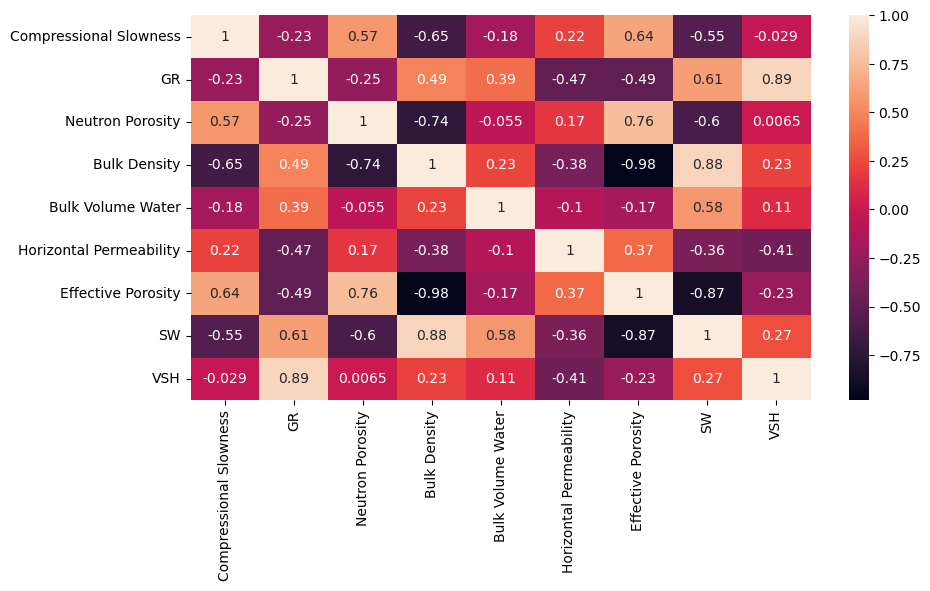

In [11]:
plt.figure(figsize=(10,5))
sns.heatmap(df_scaled.corr(), annot=True)
plt.show()

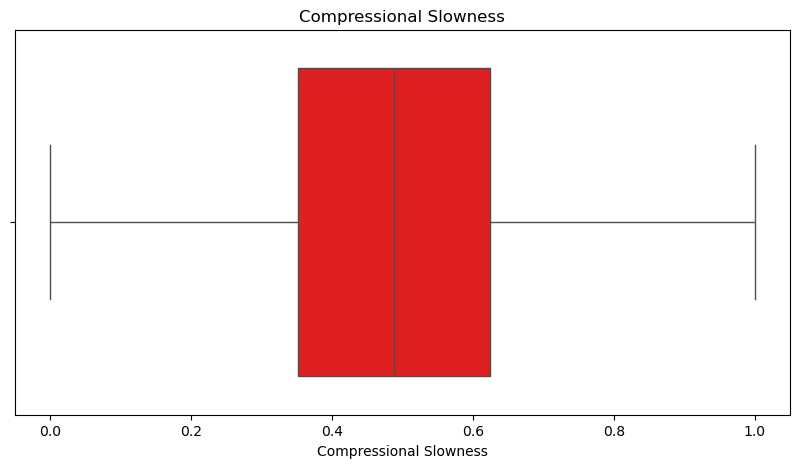

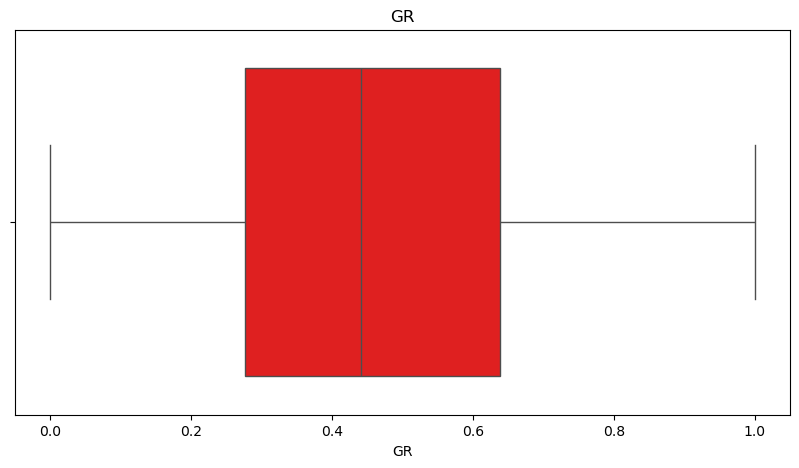

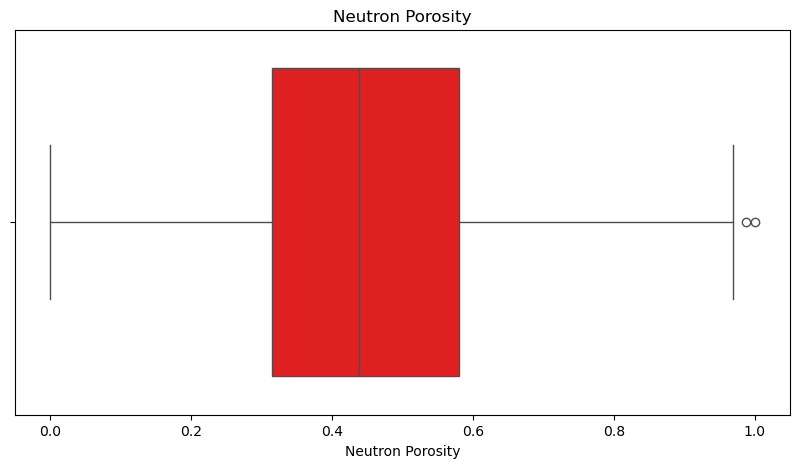

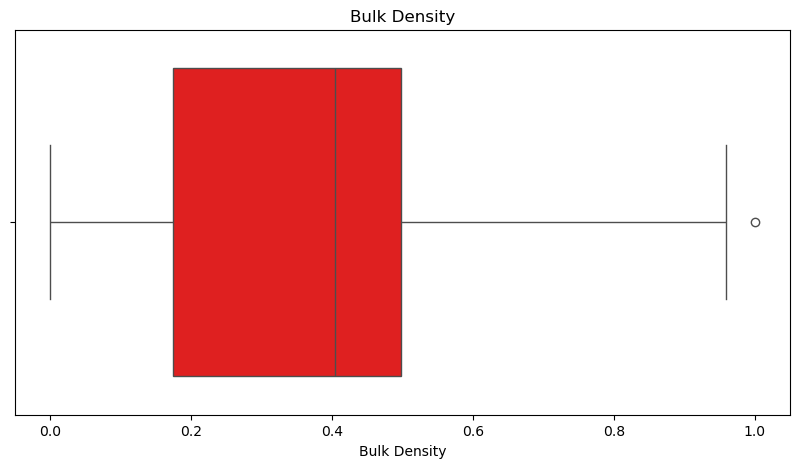

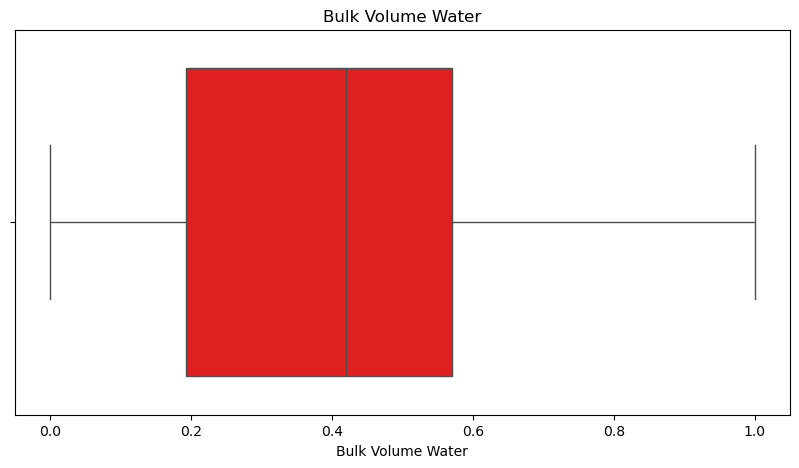

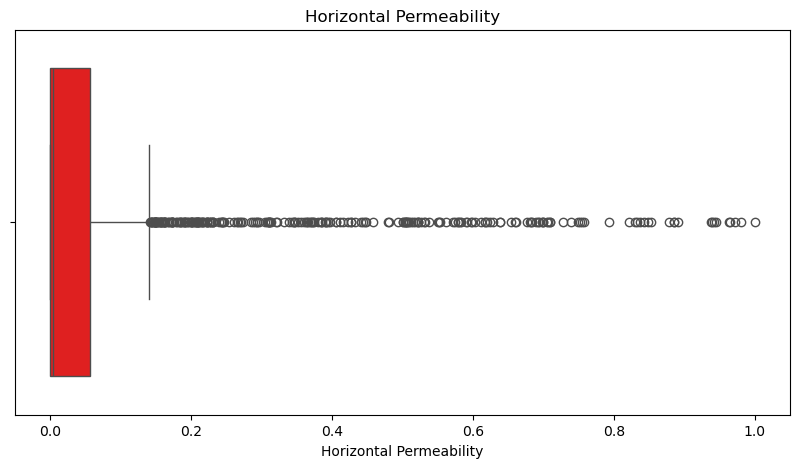

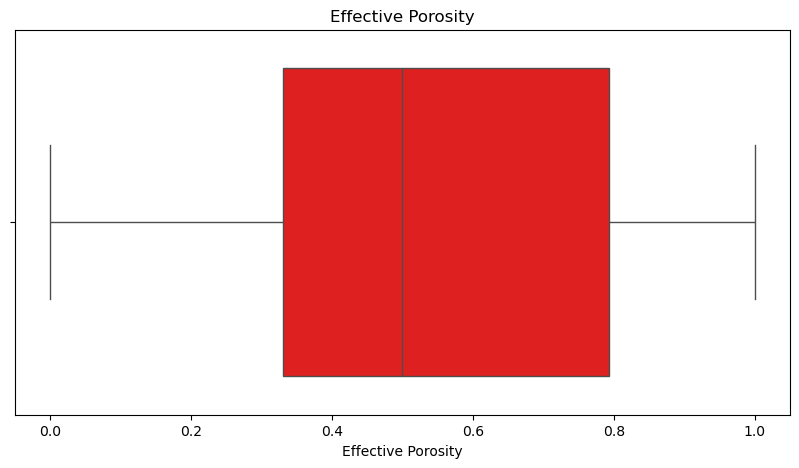

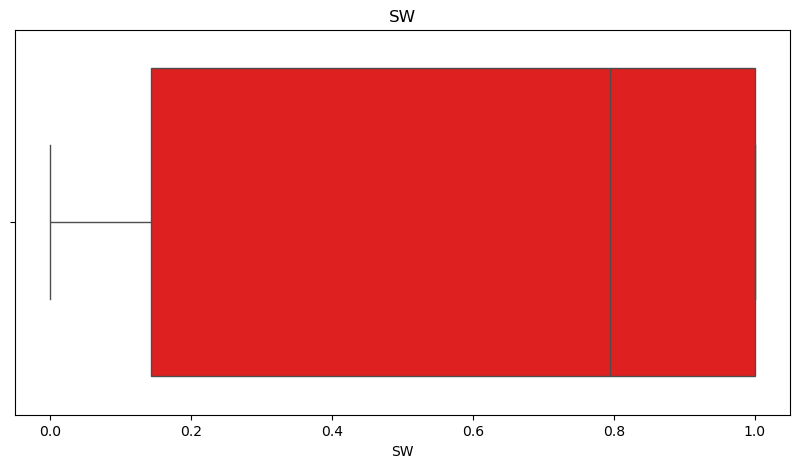

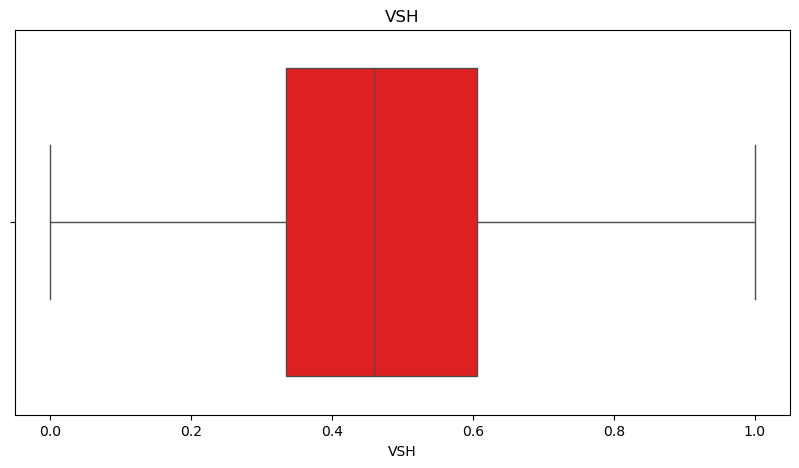

In [12]:
for i in df_scaled.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=df_scaled[i],color = 'red')
    plt.title(i)

## Preparing the data

In [13]:
# Separate features and target variable
X = df_scaled.drop(columns=['Horizontal Permeability'])
y = df_scaled['Horizontal Permeability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train Multiple Models

In [14]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'Neural Network': MLPRegressor(random_state=42, max_iter=1000)
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[model_name] = {'MAE': mae, 'MSE': mse, 'Predictions': y_pred}


## Plot Actual vs. Predicted Values

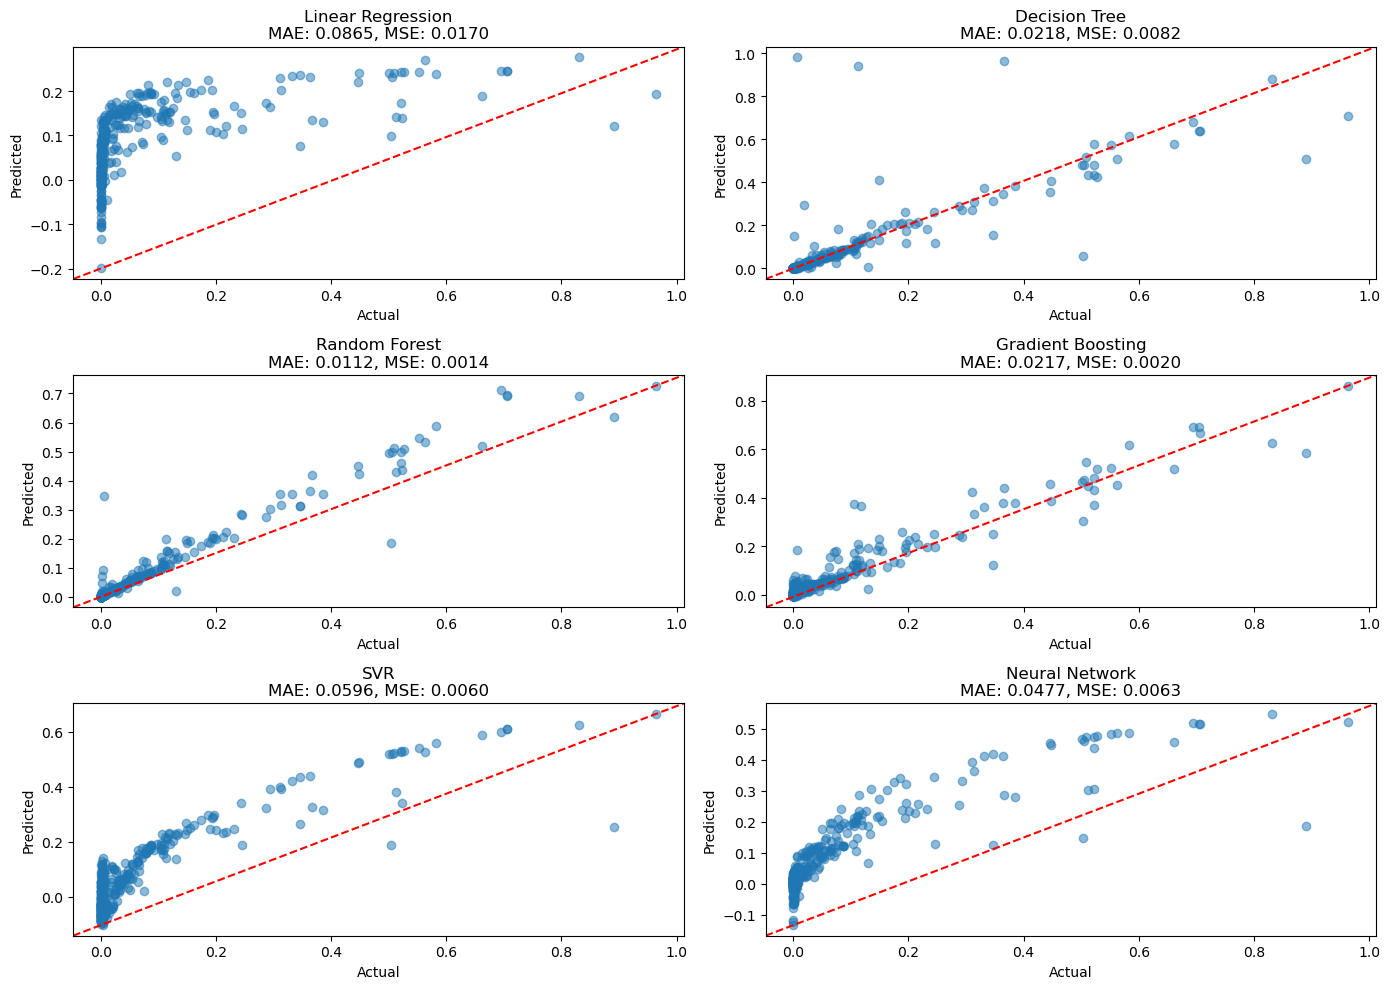

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
for i, (model_name, result) in enumerate(results.items(), 1):
    plt.subplot(3, 2, i)
    plt.scatter(y_test, result['Predictions'], alpha=0.5)
    plt.plot([0, 1], [0, 1], '--', color='red', transform=plt.gca().transAxes)
    plt.title(f'{model_name}\nMAE: {result["MAE"]:.4f}, MSE: {result["MSE"]:.4f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.tight_layout()

plt.show()


In [16]:
x_train_const = sm.add_constant(X_train)

model_fitted = sm.OLS(y_train,x_train_const).fit()
print(model_fitted.summary())

                               OLS Regression Results                              
Dep. Variable:     Horizontal Permeability   R-squared:                       0.278
Model:                                 OLS   Adj. R-squared:                  0.274
Method:                      Least Squares   F-statistic:                     64.54
Date:                     Sun, 04 Aug 2024   Prob (F-statistic):           1.70e-89
Time:                             19:36:13   Log-Likelihood:                 717.08
No. Observations:                     1347   AIC:                            -1416.
Df Residuals:                         1338   BIC:                            -1369.
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------